<a href="https://colab.research.google.com/github/capozzolicaluan/TiltmeterAnalysis/blob/main/Tiltimeter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%reset -f

In [2]:
# import drive from colab
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
# import packages
import pandas as pd
from google.colab  import files
import io
from io import StringIO
import matplotlib.pyplot as plt
from datetime import datetime
import os

In [21]:
# functions

# Convert date format function
def convert_date_format(date_string):
    # string with br date - time format "dd/mm/aaaa hh:mm:ss"
    dt_obj = datetime.strptime(date_string, '%d/%m/%Y %H:%M:%S')
    # Format as "aaaa-mm-dd hh:mm:ss"
    return dt_obj.strftime('%Y-%m-%d %H:%M:%S')

# convert datetime to hour fraction
def datetime_to_hour_frac(dt):
    return dt.hour + dt.minute / 60 + dt.second / 3600

# list tiltmeter folders
def list_folders(directory_path):

  # List folders in the directory
  folders = [f for f in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, f))]

  return(folders)

# list files in specific tiltmeter folder
def list_files(file_directory):
  # list files in specific directory
  files = [f for f in os.listdir(file_directory) if os.path.isfile(os.path.join(file_directory, f))]

  return(files)

# function to organize tiltmeter data and clear uninteresting informations
def read_tilt_data(directory_file, tilt_files_list):
  file_path_one = "{}/{}".format(directory_file, tilt_files_list[1])
  file_path_two = "{}/{}".format(directory_file, tilt_files_list[2])

  axis_one = pd.read_csv((file_path_one), parse_dates=True, delimiter = ',',engine='c')
  axis_one = axis_one['Sample Date / Time,"Location","Sensor","Value","OB Temp"'].str.split(',', expand=True)
  axis_one = axis_one.apply(lambda x: x.str.strip('"'))
  axis_one.columns = ['Sample Date / Time', 'Location', 'Sensor', 'Value', 'OB Temp']

  axis_two = pd.read_csv((file_path_two), parse_dates=True, delimiter = ',',engine='c')
  axis_two = axis_two['Sample Date / Time,"Location","Sensor","Value","OB Temp"'].str.split(',', expand=True)
  axis_two = axis_two.apply(lambda x: x.str.strip('"'))
  axis_two.columns = ['Sample Date / Time', 'Location', 'Sensor', 'Value', 'OB Temp']

  # convert date-time format
  axis_one['Sample Date / Time'] = axis_one['Sample Date / Time'].apply(convert_date_format)
  axis_two['Sample Date / Time'] = axis_two['Sample Date / Time'].apply(convert_date_format)

  # convert date-time column to datetime type
  axis_one['Sample Date / Time'] = pd.to_datetime(axis_one['Sample Date / Time'])
  axis_two['Sample Date / Time'] = pd.to_datetime(axis_two['Sample Date / Time'])

  # Definir a coluna 'datetime_column' como o índice do DataFrame
  axis_one.set_index('Sample Date / Time', inplace=True)
  axis_two.set_index('Sample Date / Time', inplace=True)

  tilt_data = pd.DataFrame()

  tilt_data['Date-time'] = axis_one.index
  tilt_data.set_index('Date-time', inplace = True)
  tilt_data['Date-time'] = tilt_data.index
  tilt_data['Tilt_axis_one'] = pd.to_numeric(axis_one['Value'])
  tilt_data['Tilt_axis_two'] = pd.to_numeric(axis_two['Value'])
  tilt_data['Temperature'] = pd.to_numeric(axis_one['OB Temp'])

  return(tilt_data)

# calculate the tilt variation velocity
def tilt_velocity(tilt_difference_column, delta_time_column):
    velocity = pd.DataFrame()
    velocity = tilt_difference_column/delta_time_column
    velocity[0] = 0

    return(velocity)

# calculate the tilt variation acceleration
def tilt_acceleration(tilt_velocity_column, delta_time_column):
    acceleration = pd.DataFrame()
    acceleration = tilt_velocity_column.diff()/delta_time_column
    acceleration[0] = 0

    return(acceleration)

def daily_stats(subdaily_index, subdaily_variable):
  subdaily_df = pd.DataFrame()
  subdaily_df['variable'] = subdaily_variable
  subdaily_df.set_index = subdaily_index
  daily_df = subdaily_df['variable'].resample('D').agg(['mean', 'std', 'min', 'max'])

  return(daily_df)

def plot_daily(daily_var, error_bar_color):
  plt.figure(figsize = ((14, 8)))
  plt.subplot(2, 1, 1)
  # Plotar a média diária com barras de erro para desvio padrão e sombras para máximos e mínimos

  #plt.plot(daily_stats.index, daily_stats['mean'], label='Média Diária', color='blue')
  plt.plot(daily_var.index, daily_var['mean'], 'o', color='red', label='Média Diária', markersize = 2)

  # Adicionar barras de erro para desvio padrão
  plt.errorbar(daily_var.index, daily_var['mean'], yerr=daily_var['std'], fmt='o', color= error_bar_color, label='Desvio Padrão', capsize = 2, markersize = 2)

  # Adicionar sombra para valores máximo e mínimo
  plt.fill_between(daily_var.index, daily_var['min'], daily_var['max'], color='gray', alpha=0.2, label='Máximo e Mínimo')

In [5]:
# 3. Adicionar o diretório ao sys.path
import sys
sys.path.append('/content/drive/MyDrive/Colab/TiltmetersAnalysis/functions/')

# 4. Importar e usar o módulo
import functions_module

In [6]:
# Path to data directory
tilt_data_directory = '/content/drive/MyDrive/Colab/TiltmetersAnalysis/data'

# List folders in the directory
folders = list_folders(directory_path = tilt_data_directory)

# files in the folder
files = list_files(file_directory = "{}/{}/".format(tilt_data_directory,folders[0]))

In [7]:
directory_path = "{}/{}/".format(tilt_data_directory,folders[0])
tilt_time_series = read_tilt_data(directory_file = directory_path, tilt_files_list = files)

In [8]:
# diff between lines
tilt_time_series['Tilt Axis One Difference'] = tilt_time_series.Tilt_axis_one.diff()
tilt_time_series['Tilt Axis Two Difference'] = tilt_time_series.Tilt_axis_two.diff()
tilt_time_series['Temperature Difference'] = tilt_time_series.Temperature.diff()

tilt_time_series['Tilt Axis One Difference'][0] = 0
tilt_time_series['Tilt Axis Two Difference'][0] = 0
tilt_time_series['Temperature Difference'][0] = 0

<ipython-input-8-12b9bf450516>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tilt_time_series['Tilt Axis One Difference'][0] = 0
<ipython-input-8-12b9bf450516>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tilt_time_series['Tilt Axis Two Difference'][0] = 0
<ipython-input-8-12b9bf450516>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tilt_time_series['Temperature Difference'][0] = 0


In [9]:
tilt_time_series['Cum Tilt Axis One'] = tilt_time_series['Tilt Axis One Difference'].cumsum()
tilt_time_series['Cum Tilt Axis Two'] = tilt_time_series['Tilt Axis Two Difference'].cumsum()

In [10]:
tilt_time_series

,Date-time,Tilt_axis_one,Tilt_axis_two,Temperature,Tilt Axis One Difference,Tilt Axis Two Difference,Temperature Difference,Cum Tilt Axis One,Cum Tilt Axis Two
Date-time,,,,,,,,,
2023-07-07 09:05:18,2023-07-07 09:05:18,0.0000,0.0000,25.79,0.0000,0.0000,0.00,0.0000,0.0000
2023-07-07 09:10:18,2023-07-07 09:10:18,-0.0003,0.0004,25.95,-0.0003,0.0004,0.16,-0.0003,0.0004
2023-07-07 09:20:18,2023-07-07 09:20:18,-0.0005,-0.0007,26.27,-0.0002,-0.0011,0.32,-0.0005,-0.0007
2023-07-07 10:40:27,2023-07-07 10:40:27,-0.0029,-0.0037,24.22,-0.0024,-0.0030,-2.05,-0.0029,-0.0037
2023-07-07 10:50:18,2023-07-07 10:50:18,-0.0028,-0.0061,22.31,0.0001,-0.0024,-1.91,-0.0028,-0.0061
...,...,...,...,...,...,...,...,...,...
2024-04-11 11:00:29,2024-04-11 11:00:29,0.0044,-0.0038,26.43,0.0011,-0.0018,-0.16,0.0044,-0.0053
2024-04-11 12:00:29,2024-04-11 12:00:29,0.0046,-0.0049,26.43,0.0002,-0.0011,0.00,0.0046,-0.0064
2024-04-11 12:30:29,2024-04-11 12:30:29,0.0046,-0.0057,26.59,0.0000,-0.0008,0.16,0.0046,-0.0072


In [11]:
# difference between times
tilt_time_series['delta_time'] = tilt_time_series['Date-time'].diff()

# NaT by date
tilt_time_series['delta_time'] = tilt_time_series['delta_time'].fillna(pd.Timedelta(seconds=0))

# column with delta time in hours
tilt_time_series['delta_time_hours'] = tilt_time_series['delta_time'].dt.total_seconds()/3600

In [12]:
tilt_time_series['Axis One Velocity'] = tilt_velocity(tilt_difference_column = tilt_time_series['Tilt Axis One Difference'], delta_time_column = tilt_time_series['delta_time_hours'])
tilt_time_series['Axis Two Velocity'] = tilt_velocity(tilt_difference_column = tilt_time_series['Tilt Axis Two Difference'], delta_time_column = tilt_time_series['delta_time_hours'])

In [13]:
tilt_time_series['Axis One Acceleration'] = tilt_acceleration(tilt_velocity_column= tilt_time_series['Axis One Velocity'], delta_time_column=tilt_time_series['delta_time_hours'])
tilt_time_series['Axis Two Acceleration'] = tilt_acceleration(tilt_velocity_column= tilt_time_series['Axis Two Velocity'], delta_time_column=tilt_time_series['delta_time_hours'])

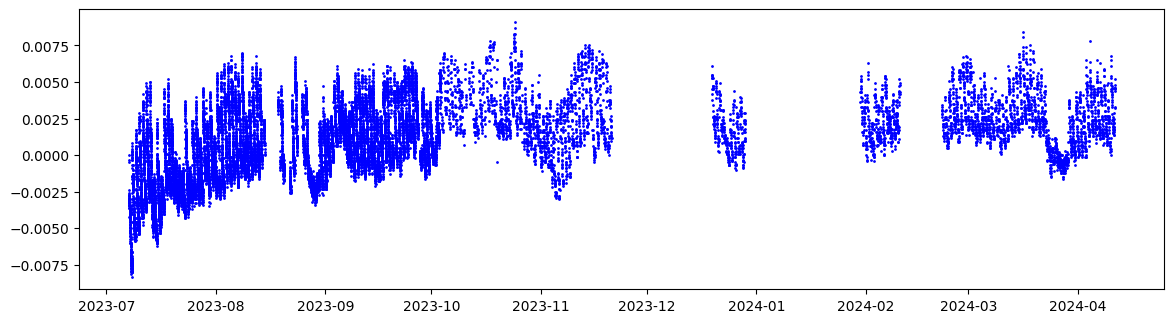

In [14]:
plt.figure(figsize = ((14, 8)))

plt.subplot(2, 1, 1)

# Plotar a média diária com barras de erro para desvio padrão e sombras para máximos e mínimos
#plt.figure(figsize=(16, 6))

#plt.plot(daily_stats.index, daily_stats['mean'], label='Média Diária', color='blue')
plt.plot(tilt_time_series.index, tilt_time_series['Tilt_axis_one'], 'o', color='blue', label='Média Diária', markersize = 1)

In [15]:
tilt_time_series

,Date-time,Tilt_axis_one,Tilt_axis_two,Temperature,Tilt Axis One Difference,Tilt Axis Two Difference,Temperature Difference,Cum Tilt Axis One,Cum Tilt Axis Two,delta_time,delta_time_hours,Axis One Velocity,Axis Two Velocity,Axis One Acceleration,Axis Two Acceleration
Date-time,,,,,,,,,,,,,,,
2023-07-07 09:05:18,2023-07-07 09:05:18,0.0000,0.0000,25.79,0.0000,0.0000,0.00,0.0000,0.0000,0 days 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
2023-07-07 09:10:18,2023-07-07 09:10:18,-0.0003,0.0004,25.95,-0.0003,0.0004,0.16,-0.0003,0.0004,0 days 00:05:00,0.083333,-0.003600,0.004800,-0.043200,0.057600
2023-07-07 09:20:18,2023-07-07 09:20:18,-0.0005,-0.0007,26.27,-0.0002,-0.0011,0.32,-0.0005,-0.0007,0 days 00:10:00,0.166667,-0.001200,-0.006600,0.014400,-0.068400
2023-07-07 10:40:27,2023-07-07 10:40:27,-0.0029,-0.0037,24.22,-0.0024,-0.0030,-2.05,-0.0029,-0.0037,0 days 01:20:09,1.335833,-0.001797,-0.002246,-0.000447,0.003260
2023-07-07 10:50:18,2023-07-07 10:50:18,-0.0028,-0.0061,22.31,0.0001,-0.0024,-1.91,-0.0028,-0.0061,0 days 00:09:51,0.164167,0.000609,-0.014619,0.014654,-0.075372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-11 11:00:29,2024-04-11 11:00:29,0.0044,-0.0038,26.43,0.0011,-0.0018,-0.16,0.0044,-0.0053,0 days 00:30:00,0.500000,0.002200,-0.003600,0.004000,0.004400
2024-04-11 12:00:29,2024-04-11 12:00:29,0.0046,-0.0049,26.43,0.0002,-0.0011,0.00,0.0046,-0.0064,0 days 01:00:00,1.000000,0.000200,-0.001100,-0.002000,0.002500
2024-04-11 12:30:29,2024-04-11 12:30:29,0.0046,-0.0057,26.59,0.0000,-0.0008,0.16,0.0046,-0.0072,0 days 00:30:00,0.500000,0.000000,-0.001600,-0.000400,-0.001000


In [16]:
daily_temperature = daily_stats(subdaily_index = tilt_time_series['Date-time'], subdaily_variable = tilt_time_series['Temperature'])

daily_tilt_one = daily_stats(subdaily_index = tilt_time_series['Date-time'], subdaily_variable = tilt_time_series['Tilt_axis_one'])
daily_tilt_two = daily_stats(subdaily_index = tilt_time_series['Date-time'], subdaily_variable = tilt_time_series['Tilt_axis_two'])

daily_velocity_one = daily_stats(subdaily_index = tilt_time_series['Date-time'], subdaily_variable = tilt_time_series['Axis One Velocity'])
daily_velocity_two = daily_stats(subdaily_index = tilt_time_series['Date-time'], subdaily_variable = tilt_time_series['Axis Two Velocity'])

daily_accelera_one = daily_stats(subdaily_index = tilt_time_series['Date-time'], subdaily_variable = tilt_time_series['Axis One Acceleration'])
daily_accelera_two = daily_stats(subdaily_index = tilt_time_series['Date-time'], subdaily_variable = tilt_time_series['Axis Two Acceleration'])

In [17]:
daily_temperature

,mean,std,min,max
Date-time,,,,
2023-07-07,17.283147,3.230712,12.45,26.27
2023-07-08,18.397590,4.939946,11.66,28.18
2023-07-09,20.144553,4.119290,15.00,29.93
2023-07-10,20.569011,4.523484,15.00,30.25
2023-07-11,21.350110,4.444860,15.31,31.83
...,...,...,...,...
2024-04-07,21.771522,2.690764,18.49,29.93
2024-04-08,22.108980,3.117184,17.70,30.09
2024-04-09,21.524000,2.257706,18.81,26.43


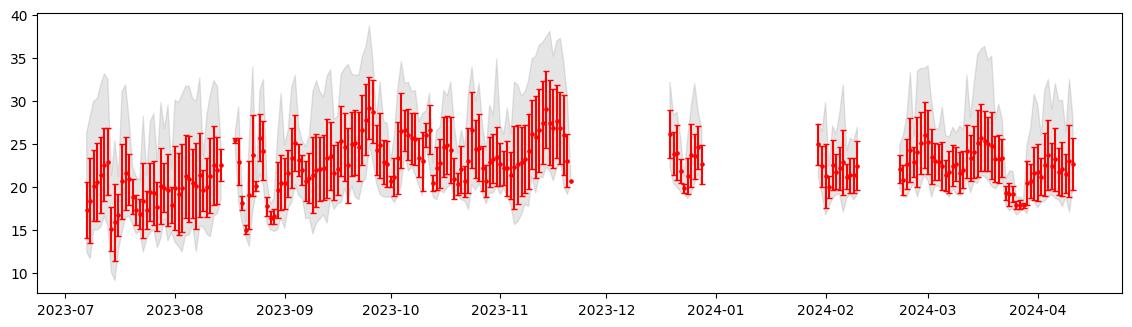

In [23]:
plot_daily(daily_var = daily_temperature, error_bar_color = 'red')

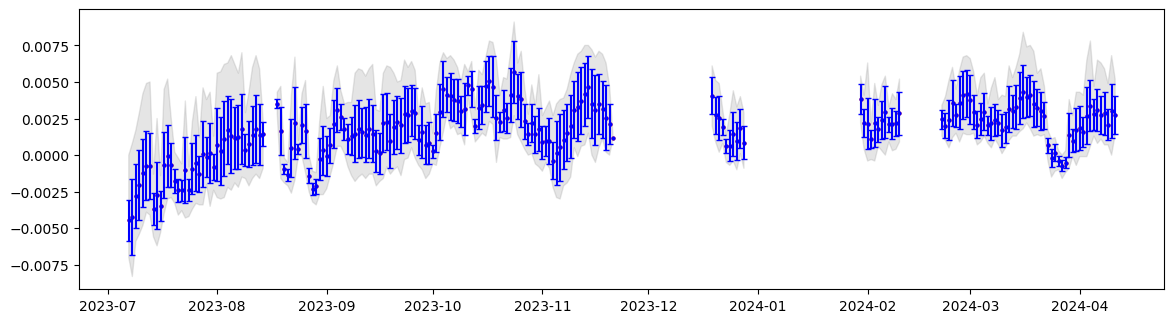

In [25]:
plot_daily(daily_var = daily_tilt_one, error_bar_color = 'blue')

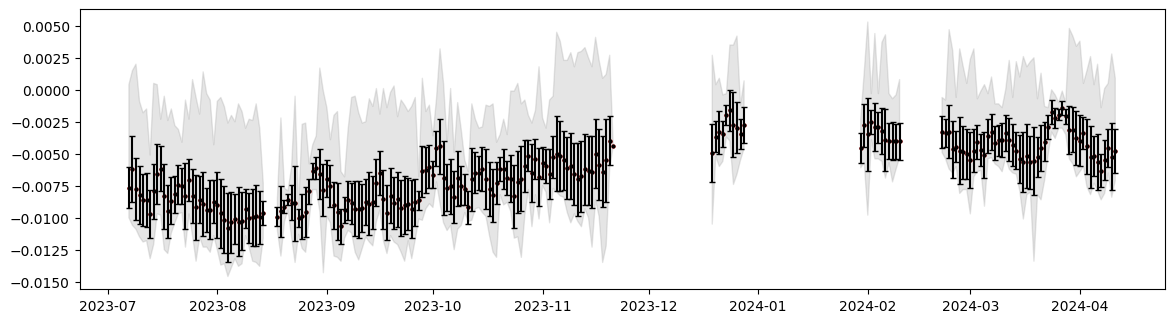

In [26]:
plot_daily(daily_var = daily_tilt_two, error_bar_color = 'blue')

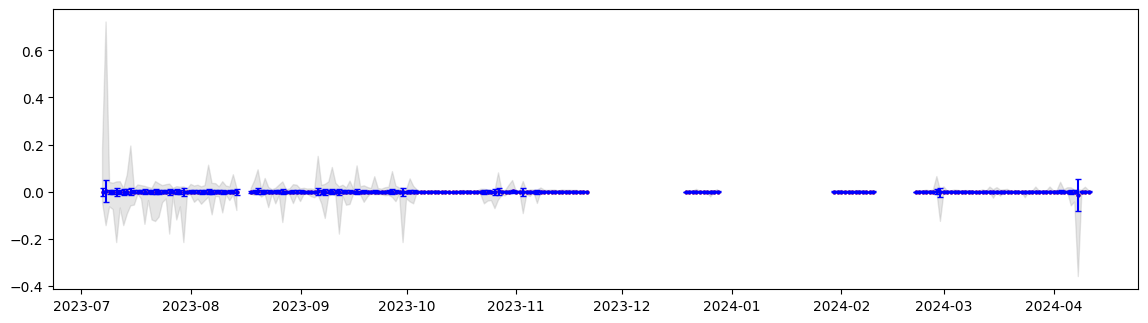

In [28]:
plot_daily(daily_var = daily_velocity_one, error_bar_color = 'blue')

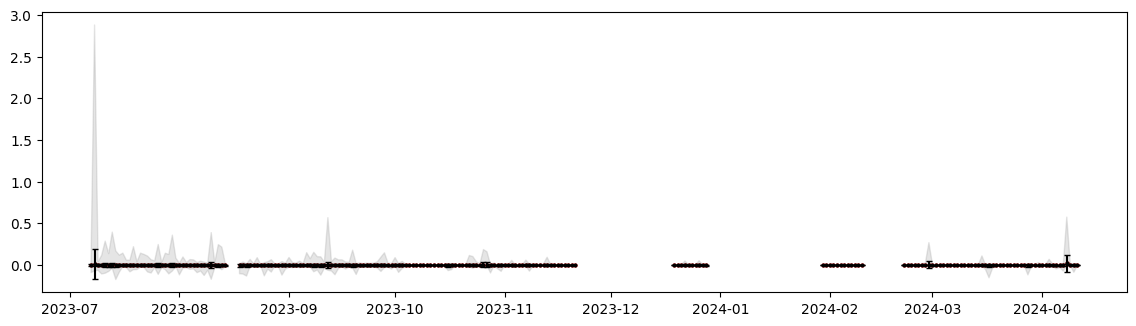

In [29]:
plot_daily(daily_var = daily_velocity_two, error_bar_color = 'black')

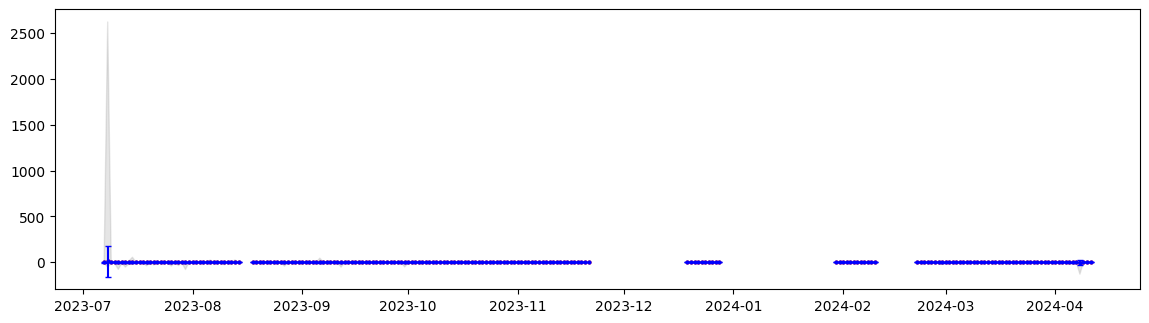

In [30]:
plot_daily(daily_var = daily_accelera_one, error_bar_color = 'blue')

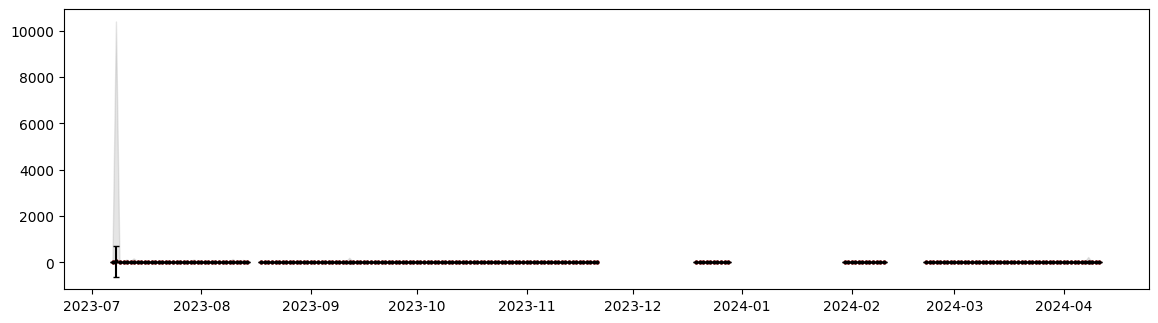

In [31]:
plot_daily(daily_var = daily_accelera_two, error_bar_color = 'black')